## Generation of visual panoramas to be tested for head direction stability

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises
from skimage.morphology import disk
from scipy.signal import convolve2d, correlate
from scipy.stats import zscore
from pathlib import Path
from os.path import sep

np.random.seed(seed=3)
%config Completer.use_jedi = False  #magic to fix autocomplete issue
%matplotlib inline

### Visibility range of the screen
#### (a) Visibility below the horizon line
This visibility range is limited by the ball surface (unless the screen is very short)

In [2]:
ballRad = 4.47 # treadmill ball radius [mm]
flyEyeAboveBall = 1 # height of eye above ball surface [mm]

print('Angle visible below horizon line:')
90-(180/np.pi)*np.arcsin(ballRad/(flyEyeAboveBall+ballRad))

Angle visible below horizon line:


35.19604924633808

#### (b) Visibility above the horizon line
This visibility range is limited by either the fly holder (pyramid) or the screen height. 
If the screen is limited, the angle it spans depends on the screen distance  which may vary along the azimuth. We will consider only the extreme values, i.e. the minimum and maximum screen distances. For the pentagonal screen that's r_min at the center of the faces and r_max at the corners. 

In [3]:
#pyramidAngle = 20 #12 for old pyramid, ideally 20 for new pyramid

screenMinDist = 4.0 # cm
screenMaxDist = 5.5 #cm

topScreenHeight = 1.7 #cm

alpha_rmin = (180/np.pi) * np.arctan( topScreenHeight / screenMinDist)
alpha_rmax = (180/np.pi) * np.arctan( topScreenHeight / screenMaxDist)

print("The screen spans an angle from {} to {} above the horizon line.".format(alpha_rmax, alpha_rmin))

The screen spans an angle from 17.175903615746744 to 23.025492008528037 above the horizon line.


### Determine approrpiate size for the texture
Choose which angle should be spanned. The texture will be sized to be displayed such that it spans the full size at the closest points on the  screen (r_min). Thus, the texture should be displayed on a cylinder with radius r_min.

In [4]:
setalpha = alpha_rmin*(np.pi/180)
height_cm = np.round(np.tan(setalpha) * screenMinDist, 2) * 2
# Values to set in unity scene:
print('Cylinder height: {} cm, Cylinder radius: {} cm'.format(height_cm/2, screenMinDist))

Cylinder height: 1.7 cm, Cylinder radius: 4.0 cm


In [5]:
pt_per_cm = 150
dpiVal = 600

panHeight_px = int(height_cm * pt_per_cm)
panWidth_px = int(2*np.pi*screenMinDist*pt_per_cm)

maxBit = 255 #assuming 8bit image depth

## Stimulus for screen position calibration

In [6]:
dotSizeAng = 5 #aim for x deg dot

#covnert angular dot size to pixel size and make dot
dotRad = panHeight_px * 0.5 * 0.5 * dotSizeAng/( setalpha*180/np.pi )
mydot = disk(radius=dotRad)

dotpos_x = panWidth_px * 72./360. * np.asarray([0, 1, 2, 3, 4])
dotpos_y = panHeight_px * np.asarray([0.2, 0.25, 0.3, 0.35, 0.4])

pan = np.zeros((panWidth_px,panHeight_px),dtype=np.uint8)
for i in range(len(dotpos_x)):
    pan[round(dotpos_x[i]), round(dotpos_y[i])] = maxBit
pan[round(dotpos_x[0]), round(dotpos_y[0])] = maxBit/2
pan[:,:] = convolve2d(pan[:,:], mydot, boundary = 'wrap', mode='same')
pan = np.minimum(maxBit, pan)

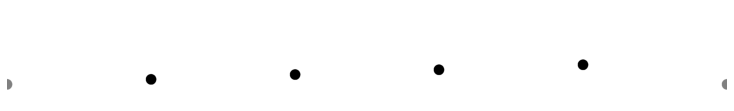

In [7]:
# make directory if it does not already exist
Path("panoramas").mkdir(parents=True, exist_ok=True)
        
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(pan.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"screenMap_darkSpot.png",dpi = dpiVal)

## Stimulus for brightness calibration

In [8]:
panHeight = 948
panWidth = 584
stepLevels_high = np.linspace(0,6,panHeight+1).astype('int')[:-1]*maxBit/10
panStripe_high = np.tile(stepLevels_high, panWidth).reshape(panWidth,panHeight).astype('int')
stepLevels_low = np.linspace(5,11,panHeight+1).astype('int')[:-1]*maxBit/10
panStripe_low = np.tile(stepLevels_low, panWidth).reshape(panWidth,panHeight).astype('int')

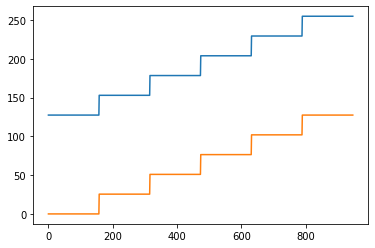

In [9]:
plt.plot(stepLevels_low)
plt.plot(stepLevels_high)

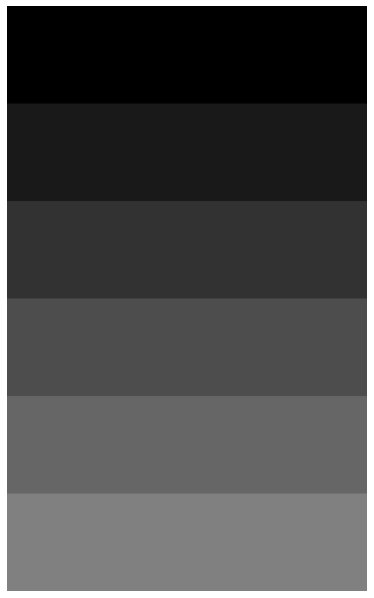

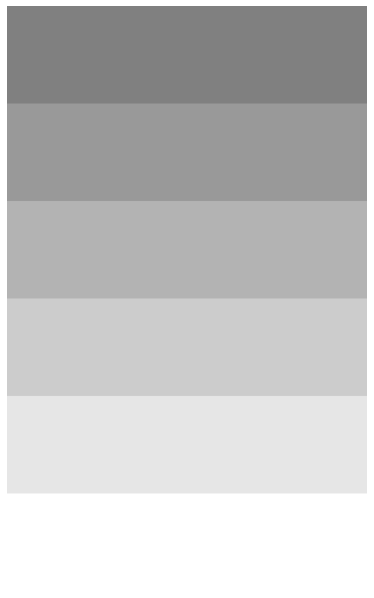

In [10]:
# make directory if it does not already exist
Path("calibration").mkdir(parents=True, exist_ok=True)

fig = plt.figure(frameon=False)
fig.set_size_inches(5,5*panHeight/panWidth)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panStripe_low.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("calibration"+sep+"BrightnessSteps_low.png",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(5,5*panHeight/panWidth)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panStripe_high.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("calibration"+sep+"BrightnessSteps_high.png",dpi = dpiVal)

## Stimuli for receptive field mapping

In [11]:
dotSizeAng = 5 #aim for x deg dot

#covnert angular dot size to pixel size and make dot
dotRad = panHeight_px * 0.5 * 0.5 * dotSizeAng/( setalpha*180/np.pi )
mydot = disk(radius=dotRad)

dotpos_x = 0
dotpos_y = int(0-dotRad)

pan = np.zeros((panWidth_px,panHeight_px),dtype=np.uint8)
pan[dotpos_x, dotpos_y] = maxBit
pan[:,:] = convolve2d(pan[:,:], mydot, boundary = 'wrap', mode='same')

pan = np.minimum(maxBit, pan)

In [12]:
darkSpot = pan[:,:]
brightSpot = abs(maxBit - darkSpot)

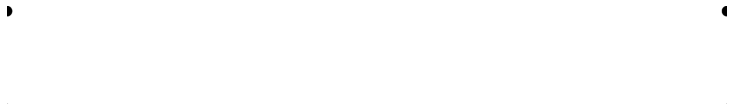

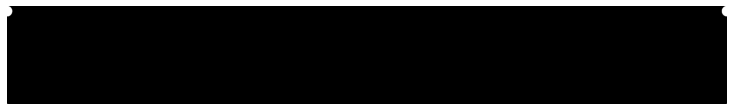

In [13]:
# make directory if it does not already exist
Path("panoramas").mkdir(parents=True, exist_ok=True)
        
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(darkSpot.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"RF1_darkSpot.png",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(brightSpot.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)

fig.savefig("panoramas"+sep+"RF2_brightSpot.png", dpi = dpiVal)

## Stimuli with clear orientation information
Vary just the brightness and test on vs. off features
### (1) Generate a sun spot and the inverse image 

In [14]:
dotSizeAng = 12 #aim for x deg dot

#convert angular dot size to pixel size and make dot
dotRad = panHeight_px * 0.5 * 0.5 * dotSizeAng/( setalpha*180/np.pi )
mydot = disk(radius=dotRad)

dotpos_x = round(panWidth_px/2)
dotpos_y = round((panHeight_px + dotRad)/2)

pan = np.zeros((panWidth_px,panHeight_px),dtype=np.uint8)
pan[dotpos_x, dotpos_y] = maxBit
pan[:,:] = convolve2d(pan[:,:], mydot, boundary = 'wrap', mode='same')

pan = np.minimum(maxBit, pan)

In [15]:
darkSpot = pan[:,:]
brightSpot = abs(maxBit - darkSpot)

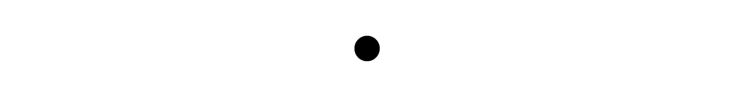

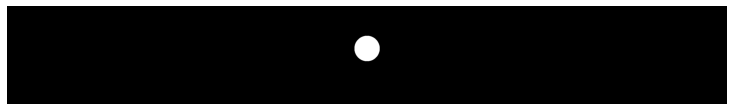

In [16]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(darkSpot.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"A1_darkSpot.png",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(brightSpot.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"A2_brightSpot.png", dpi = dpiVal)

#### Generate two sun panoramas with matching overall brightness but opposide contrast

In [17]:
panOn = darkSpot
panOff = maxBit-panOn
panOn = np.minimum(maxBit, panOn)
panOff = np.minimum(maxBit, panOff)

dotRatio = np.sum(panOn/maxBit)/(panWidth_px*panHeight_px)
panOn_shift = panOn/2 + (0.5-dotRatio*0.5)*maxBit
panOff_shift = panOff/2

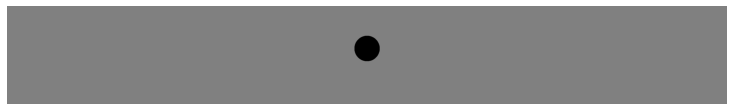

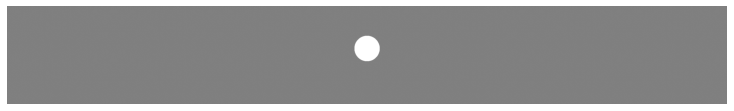

In [18]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panOn_shift.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"B1_darkOnGrey.png",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panOff_shift.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"B2_brightOnGrey.png", dpi = dpiVal)

In [19]:
print(np.sum(panOn))
print(np.sum(panOff))

print(np.sum(panOn_shift)/np.sum(panOff_shift))

3531240
486627210
1.0072565609309052


**Follow up stimulus with darker grey background**

In [20]:
panOn_dark = panOn_shift + 0.2*maxBit
panOff_dark = panOff_shift + 0.2*maxBit
panOn_dark = np.minimum(maxBit, panOn_dark)
panOff_dark[panOff_dark < 0.5*maxBit] = np.median(panOn_dark) - (maxBit - np.median(panOn_dark))

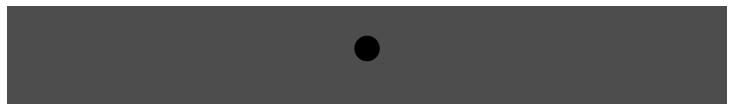

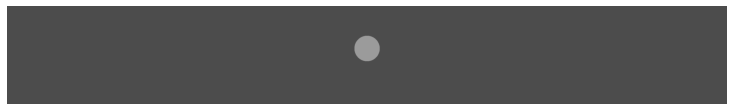

In [21]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panOn_dark.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"B1d_darkOnDarkGrey.png",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panOff_dark.T,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"B2d_brightOnDarkGrey.png", dpi = dpiVal)

In [22]:
print(np.sum(panOn_dark)/np.sum(panOff_dark))

1.0011440181700701


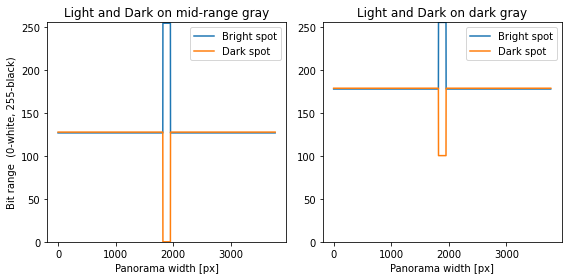

In [23]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

axs[0].plot(panOn_shift.T[dotpos_y,:], label='Bright spot')
axs[0].plot(panOff_shift.T[dotpos_y,:], label='Dark spot')
axs[0].set_title('Light and Dark on mid-range gray')

axs[1].plot(panOn_dark.T[dotpos_y,:], label='Bright spot')
axs[1].plot(panOff_dark.T[dotpos_y,:], label='Dark spot')
axs[1].set_title('Light and Dark on dark gray')

for ax in axs:
    ax.set_ylim((0,maxBit))
    ax.set_xlabel('Panorama width [px]')
    ax.legend()
axs[0].set_ylabel('Bit range  (0-white, {}-black)'.format(maxBit));
fig.tight_layout()

### (2) Generate a gradient

In [24]:
panGrad = np.tile( (np.sin(np.linspace(np.pi,np.pi*3,panWidth_px)) + 1)*maxBit/2 ,panHeight_px).reshape(panHeight_px,panWidth_px)
panGradLow = np.tile( (np.sin(np.linspace(np.pi,np.pi*3,panWidth_px)) + 2)*maxBit/4 ,panHeight_px).reshape(panHeight_px,panWidth_px)
panGradVeryLow = np.tile( (np.sin(np.linspace(np.pi,np.pi*3,panWidth_px)) + 4)*maxBit/8 ,panHeight_px).reshape(panHeight_px,panWidth_px)

panGradLowBright = np.tile( (np.sin(np.linspace(np.pi,np.pi*3,panWidth_px)) + 2)*maxBit/4 - maxBit/4 ,panHeight_px).reshape(panHeight_px,panWidth_px)
panGradVeryLowBright = np.tile( (np.sin(np.linspace(np.pi,np.pi*3,panWidth_px)) + 4)*maxBit/8 - 3*maxBit/8 ,panHeight_px).reshape(panHeight_px,panWidth_px)

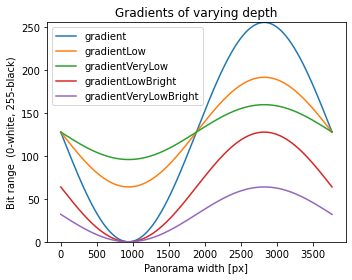

In [25]:
fig, axs = plt.subplots(1,1,figsize=(5,4))
axs.plot(panGrad[0,:], label='gradient')
axs.plot(panGradLow[0,:], label='gradientLow')
axs.plot(panGradVeryLow[0,:], label='gradientVeryLow')
axs.plot(panGradLowBright[0,:], label='gradientLowBright')
axs.plot(panGradVeryLowBright[0,:], label='gradientVeryLowBright')
axs.set_title('Gradients of varying depth')
axs.set_ylim((0,maxBit))
axs.set_xlabel('Panorama width [px]')
axs.set_ylabel('Bit range  (0-white, {}-black)'.format(maxBit));
axs.legend()
fig.tight_layout()

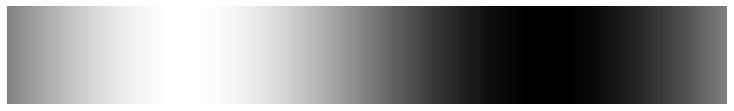

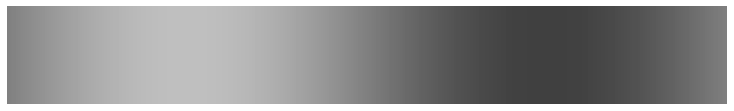

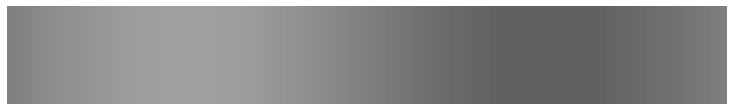

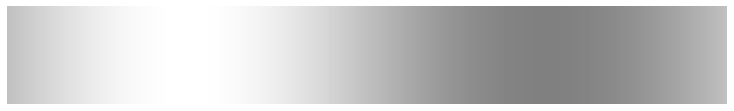

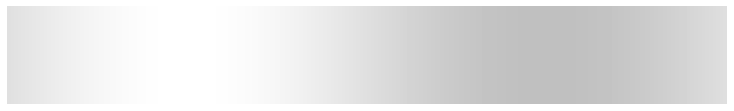

In [26]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panGrad,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"C1_gradient.png",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panGradLow,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"C2_gradientLow.png",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panGradVeryLow,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"C3_gradientVeryLow.png",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panGradLowBright.astype('int'),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"C4_gradientLowBright.png",dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(panGradVeryLowBright,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"C5_gradientVeryLowBright.png",dpi = dpiVal)

### (3) Generate a gradient with sunspots of varying brightness

In [27]:
panLeftShifted = np.roll(pan, -int(np.shape(pan)[0]/4), axis = 0)

In [28]:
brightStr = np.array(["High","Mid","Low"])

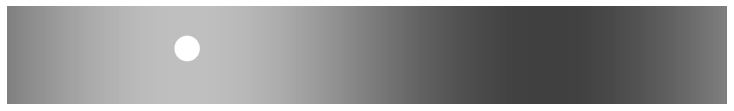

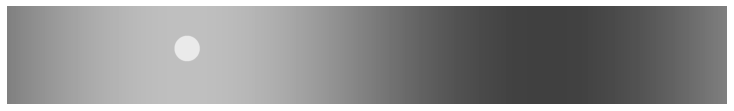

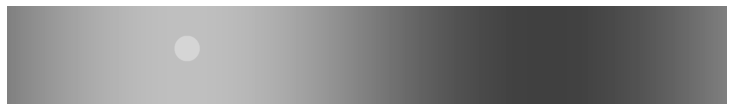

In [29]:
brightRange = np.linspace(0,np.min(panGradLow),len(brightStr)+1)
for i,bStr in enumerate(brightStr):
    spotBrightness = brightRange[i]
    panSpotGradLow = np.where(panLeftShifted.T>0,spotBrightness,panGradLow)
    fig = plt.figure(frameon=False)
    fig.set_size_inches(10,10*panHeight_px/panWidth_px)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(panSpotGradLow,origin='lower', cmap='binary', vmin=0, vmax=maxBit)
    fig.savefig("panoramas"+sep+"C2"+"S"+str(i+1)+"_panoramaSpot"+bStr+"GradientLow.png",dpi = dpiVal)

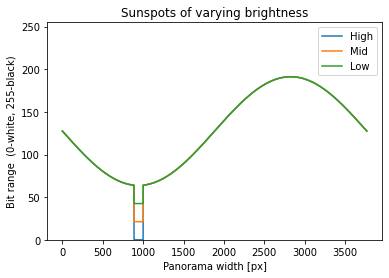

In [30]:
for i,bStr in enumerate(brightStr):
    spotBrightness = brightRange[i]
    panSpotGradLow = np.where(panLeftShifted.T>0,spotBrightness,panGradLow)
    plt.plot(panSpotGradLow[int(np.shape(panSpotGradLow)[0]/2),:],label=bStr)
plt.ylim(0,maxBit)
plt.title('Sunspots of varying brightness')
plt.xlabel('Panorama width [px]')
plt.ylabel('Bit range  (0-white, {}-black)'.format(maxBit));
plt.legend()
plt.savefig("plots"+sep+"disappearing_sunspot_profile.pdf")

### (3) Generate reshaped panoramas

In [31]:
import pandas as pd
from scipy.optimize import minimize
import scipy as sp

Dir = 'screenMeasurements/' #"/Volumes/jayaramanlab/Shivam/" #connect to dm11
rig = "Hannah" #"Shivam"#

if rig == "Shivam":
    file2 = rig+"Rig_mean_brightness_level_6.csv"
else:
    file2 = rig+"Rig_mean_brightness.csv"
    
file = rig+"Rig_lookup_table_transformed_brightness.csv"

lookupDf = pd.read_csv(Dir+file)
mean_brightness = pd.read_csv(Dir+file2)

In [32]:
maxBit = 255 #assuming 8bit image depth
npts = 1000

def rescale(img):
    x = img.flatten()
    y = np.array(lookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

def simulateI(img):
    x = img.flatten()
    y = np.array(transformDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

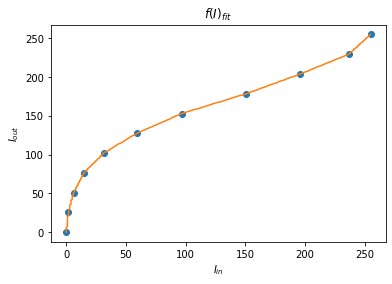

In [33]:
y = np.array(mean_brightness['I'].values)
x = np.arange(0,256,1)
y = np.zeros(x.shape)

b = sp.interpolate.interp1d(mean_brightness['I'], mean_brightness['Stim'],bounds_error=False)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(mean_brightness['I'].values,mean_brightness['Stim'].values,'o');
plt.plot(np.round(y).astype('int'),x)
plt.title(r'$f(I)_{fit}$')
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");

transformDf = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

**Generate and save simulated original gradients**

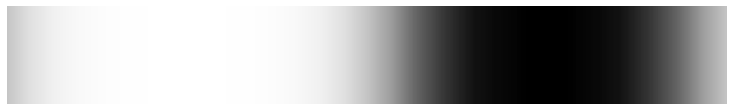

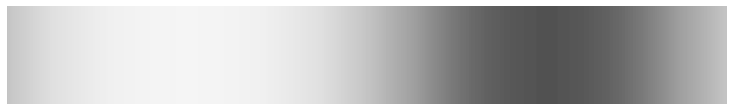

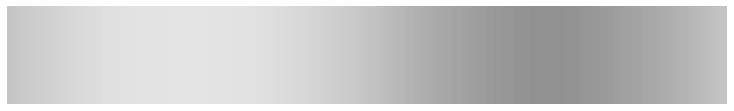

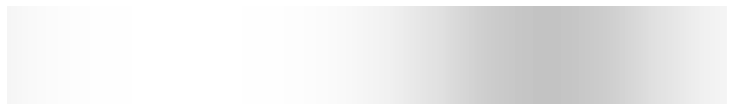

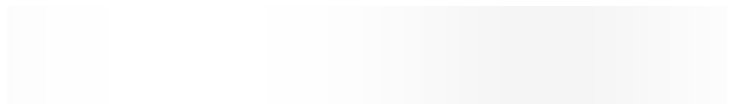

In [34]:
# make directory if it does not already exist
Path("panoramas/simulated").mkdir(parents=True, exist_ok=True)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(simulateI(panGrad),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+'simulated'+sep+"C1_gradient_simulated_{}Rig.png".format(rig),dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(simulateI(panGradLow),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"simulated"+sep+"C2_gradientLow_simulated_{}Rig.png".format(rig),dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(simulateI(panGradVeryLow),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"simulated"+sep+"C3_gradientVeryLow_simulated_{}Rig.png".format(rig),dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(simulateI(panGradLowBright),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"simulated"+sep+"C4_gradientLowBright_simulated_{}Rig.png".format(rig),dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(simulateI(panGradVeryLowBright),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"simulated"+sep+"C5_gradientVeryLowBright_simulated_{}Rig.png".format(rig),dpi = dpiVal)

**Generate and save reshaped gradients**

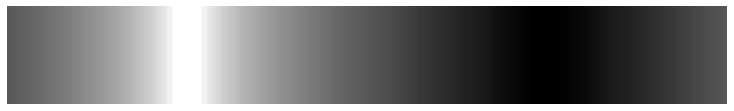

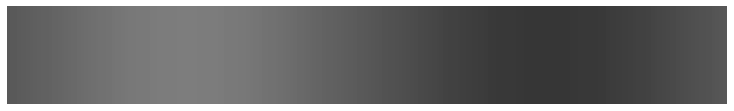

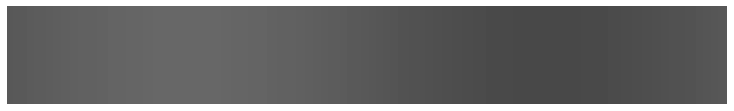

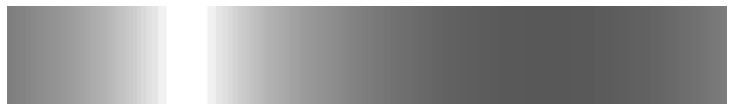

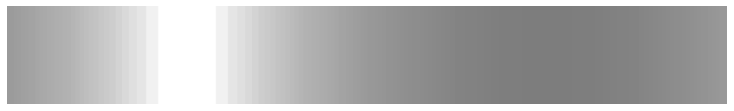

In [35]:
# make directory if it does not already exist
Path("panoramas/reshaped").mkdir(parents=True, exist_ok=True)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(rescale(panGrad),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C1_gradient_reshaped_{}Rig.png".format(rig),dpi = dpiVal)


fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(rescale(panGradLow),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C2_gradientLow_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(rescale(panGradVeryLow),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C3_gradientVeryLow_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(rescale(panGradLowBright),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C4_gradientLowBright_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

fig = plt.figure(frameon=False)
fig.set_size_inches(10,10*panHeight_px/panWidth_px)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(rescale(panGradVeryLowBright),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
fig.savefig("panoramas"+sep+"reshaped"+sep+"C5_gradientVeryLowBright_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

### Reshape gradients with sunspot

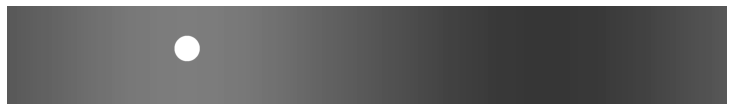

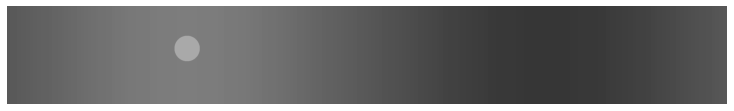

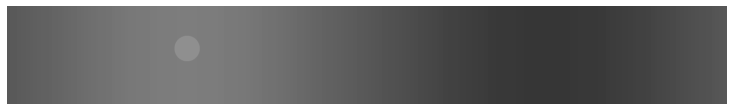

In [36]:
brightRange = np.linspace(0,np.min(panGradLow),len(brightStr)+1)
for i,bStr in enumerate(brightStr):
    spotBrightness = brightRange[i]
    panSpotGradLow = np.where(panLeftShifted.T>0,spotBrightness,panGradLow)
    fig = plt.figure(frameon=False)
    fig.set_size_inches(10,10*panHeight_px/panWidth_px)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(rescale(panSpotGradLow),origin='lower', cmap='binary', vmin=0, vmax=maxBit)
    fig.savefig("panoramas"+sep+"reshaped"+sep+"C2"+"S"+str(i+1)+"_panoramaSpot"+bStr+"GradientLow_reshaped_{}Rig.png".format(rig),dpi = dpiVal)

### Reshape sky gradients

In [37]:
pt_per_cm = 150
dpiVal = 1000

maxBitSave = 2000

savename = '13h'
path = './skyGradients/'+savename+'/'

for side, name in enumerate(['Back','Right','Front','Left','Up','Down']):

    grad = np.asarray(Image.open(path + 'Skybox_mean_{}_{}.png'.format(name,savename)))

    fig = plt.figure(frameon=False)
    fig.set_size_inches(5,5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(rescale(grad), cmap='binary')
    fig.savefig(path+"Skybox_reshaped_{}_{}_{}.png".format(name,savename,rig),dpi = dpiVal)

NameError: name 'Image' is not defined